Importación y Carga de Datos

In [1]:
# Importaciones correctas
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

df = pd.read_csv('Telco Churn dataset 2.csv')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preprocesamiento

In [2]:
# 1. Preprocesamiento
# a. Crear la columna 'Churn' y asignar 1 si 'Churn' es 'Yes', de lo contrario 0
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# b. Eliminar columnas con más del 50% de datos faltantes
threshold = int(0.5 * len(df))
df = df.dropna(thresh=threshold, axis=1)

# c. Reemplazar valores atípicos por la media
for col in df.select_dtypes(include=['float64', 'int64']):
    if col != 'Churn':  # Asegurarse de no modificar la columna 'Churn'
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df[col] = df[col].apply(lambda x: df[col].mean() if (x < (Q1 - 1.5 * IQR)) or (x > (Q3 + 1.5 * IQR)) else x)

# d. Convertir variables categóricas a numéricas y llenar valores faltantes
for column in df.columns:
    if df[column].dtype == 'object' and column != 'Churn':
        df[column].fillna(df[column].mode()[0], inplace=True)
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
    elif df[column].dtype in ['int64', 'float64']:
        df[column].fillna(df[column].median(), inplace=True)

# e. Normalización
cols_to_scale = df.columns.tolist()
cols_to_scale.remove('Churn')
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# f. Asegurarse de que 'Churn' sea int
df['Churn'] = df['Churn'].astype(int)


Selección de características

In [3]:
# 2. Selección de características
xgb_for_feature_selection = XGBClassifier(
    objective='binary:logistic', 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)
xgb_for_feature_selection.fit(df.drop('Churn', axis=1), df['Churn'])
threshold = 0.01  
selected_features = df.drop('Churn', axis=1).columns[(xgb_for_feature_selection.feature_importances_ > threshold)].tolist()
print("Características seleccionadas:", selected_features)

Características seleccionadas: ['customerID', 'SeniorCitizen', 'tenure', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'InternationalPlan', 'VoiceMailPlan', 'NumbervMailMessages', 'TotalDayMinutes', 'TotalEveMinutes', 'TotalNightMinutes', 'TotalIntlMinutes', 'TotalIntlCalls', 'CustomerServiceCalls']


Balanceo con SMOTE

In [4]:
# 3. Balanceo con SMOTE
X = df[selected_features]
y = df['Churn']
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

División de Conjunto

In [5]:
# 4. División de Conjunto
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

Definición de la función para crear el modelo ANN

In [6]:
# 5. Definición de la función para crear el modelo ANN
def create_ann_model(learning_rate=0.001):  # Added learning_rate argument with a default value
    ann_model = Sequential()
    ann_model.add(Dense(48, activation='relu', input_dim=len(selected_features)))
    ann_model.add(Dense(1, activation='sigmoid'))  # salida binaria
    ann_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])  # Used learning_rate argument
    return ann_model

ann_model = KerasClassifier(build_fn=create_ann_model, epochs=100, batch_size=32, verbose=0)

Inicializar modelos con los hiperparámetros óptimos encontrados

In [7]:
# 5. Inicializar modelos con los hiperparámetros óptimos encontrados
def objective(trial):
    # Hiperparámetros sugeridos
    xgb_params = {
        'subsample': trial.suggest_float('xgb__subsample', 0.1, 1),
        'scale_pos_weight': trial.suggest_float('xgb__scale_pos_weight', 1, 10),
        'reg_lambda': trial.suggest_float('xgb__reg_lambda', 0.1, 10),
        'n_estimators': trial.suggest_int('xgb__n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('xgb__max_depth', 1, 10),
        'learning_rate': trial.suggest_float('xgb__learning_rate', 0.01, 1, log=True),
        'gamma': trial.suggest_float('xgb__gamma', 0, 1),
        'colsample_bytree': trial.suggest_float('xgb__colsample_bytree', 0.1, 1),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    rf_params = {
        'n_estimators': trial.suggest_int('rf__n_estimators', 100, 1000),
        'min_samples_split': trial.suggest_int('rf__min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf__min_samples_leaf', 1, 20),
        'max_depth': trial.suggest_int('rf__max_depth', 1, 10),
        'bootstrap': trial.suggest_categorical('rf__bootstrap', [True, False]),
        'random_state': 42
    }

    ann_params = {
        'epochs': trial.suggest_int('ann__epochs', 10, 200),
        'batch_size': trial.suggest_int('ann__batch_size', 16, 128),
        'learning_rate': trial.suggest_float('ann__learning_rate', 1e-5, 1e-1, log=True)
    }
    xgb_model = XGBClassifier(**xgb_params)
    rf_model = RandomForestClassifier(**rf_params)
    ann_model = KerasClassifier(build_fn=lambda learning_rate=ann_params['learning_rate']: create_ann_model(learning_rate), **ann_params)

    voting_clf = VotingClassifier(
        estimators=[('xgb', xgb_model), ('ann', ann_model), ('rf', rf_model)],
        voting='soft'
    )
    voting_clf.fit(X_train, y_train)
    y_pred = voting_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

Crear un Voting Classifier con soft voting

In [8]:
# 7. Creación del estudio Optuna
initial_params = {
    'xgb__subsample': 0.8585032378891985,
    'xgb__scale_pos_weight': 2.686299663676034,
    'xgb__reg_lambda': 9.777372270241651,
    'xgb__n_estimators': 541,
    'xgb__max_depth': 6,
    'xgb__learning_rate': 0.591565643324633,
    'xgb__gamma': 0.004041065299798887,
    'xgb__colsample_bytree': 0.6693673534860863,
    'rf__n_estimators': 508,
    'rf__min_samples_split': 12,
    'rf__min_samples_leaf': 16,
    'rf__max_depth': 8,
    'rf__bootstrap': False,
    'ann__epochs': 132,
    'ann__batch_size': 60,
    'ann__learning_rate': 0.005501378205040184
}
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.enqueue_trial(initial_params)
study.optimize(objective, n_trials=50, timeout=None)  # Puede ajustar n_trials y timeout según sus necesidades

[I 2023-11-05 23:24:03,719] A new study created in memory with name: no-name-77aa4727-de2b-4044-99fe-802a98e85139
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
2023-11-05 23:24:05.215710: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-05 23:24:05.215737: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-05 23:24:05.215755: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-05 23:24:05.215962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-05 23:24:05.215979: I tensorflow/core/common_runtime/pluggable_de

Epoch 1/132


2023-11-05 23:24:06.137072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


76/76 [==============================] - 4s 12ms/step - loss: 0.4484 - accuracy: 0.7893
Epoch 2/132
76/76 [==============================] - 1s 11ms/step - loss: 0.4083 - accuracy: 0.8077
Epoch 3/132
76/76 [==============================] - 1s 11ms/step - loss: 0.4050 - accuracy: 0.8099
Epoch 4/132
76/76 [==============================] - 1s 10ms/step - loss: 0.4084 - accuracy: 0.8101
Epoch 5/132
76/76 [==============================] - 1s 7ms/step - loss: 0.4120 - accuracy: 0.8068
Epoch 6/132
76/76 [==============================] - 0s 7ms/step - loss: 0.4052 - accuracy: 0.8096
Epoch 7/132
76/76 [==============================] - 1s 7ms/step - loss: 0.4105 - accuracy: 0.8070
Epoch 8/132
76/76 [==============================] - 0s 6ms/step - loss: 0.4094 - accuracy: 0.8033
Epoch 9/132
76/76 [==============================] - 0s 6ms/step - loss: 0.4133 - accuracy: 0.8035
Epoch 10/132
76/76 [==============================] - 1s 7ms/step - loss: 0.4153 - accuracy: 0.8039
Epoch 11/132
76/7

[I 2023-11-05 23:25:41,894] Trial 0 finished with value: 0.9298245614035088 and parameters: {'xgb__subsample': 0.8585032378891985, 'xgb__scale_pos_weight': 2.686299663676034, 'xgb__reg_lambda': 9.777372270241651, 'xgb__n_estimators': 541, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.591565643324633, 'xgb__gamma': 0.004041065299798887, 'xgb__colsample_bytree': 0.6693673534860863, 'rf__n_estimators': 508, 'rf__min_samples_split': 12, 'rf__min_samples_leaf': 16, 'rf__max_depth': 8, 'rf__bootstrap': False, 'ann__epochs': 132, 'ann__batch_size': 60, 'ann__learning_rate': 0.005501378205040184}. Best is trial 0 with value: 0.9298245614035088.


Epoch 1/44


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 6s 24ms/step - loss: 0.6052 - accuracy: 0.6721
Epoch 2/44
127/127 [==============================] - 1s 8ms/step - loss: 0.5184 - accuracy: 0.7533
Epoch 3/44
127/127 [==============================] - 1s 8ms/step - loss: 0.4784 - accuracy: 0.7822
Epoch 4/44
127/127 [==============================] - 1s 12ms/step - loss: 0.4554 - accuracy: 0.7930
Epoch 5/44
127/127 [==============================] - 2s 15ms/step - loss: 0.4404 - accuracy: 0.8015
Epoch 6/44
127/127 [==============================] - 2s 15ms/step - loss: 0.4303 - accuracy: 0.8088
Epoch 7/44
127/127 [==============================] - 2s 15ms/step - loss: 0.4228 - accuracy: 0.8118
Epoch 8/44
127/127 [==============================] - 2s 12ms/step - loss: 0.4175 - accuracy: 0.8147
Epoch 9/44
127/127 [==============================] - 1s 8ms/step - loss: 0.4134 - accuracy: 0.8167
Epoch 10/44
127/127 [==============================] - 1s 7ms/step - loss: 0.4101 - accuracy: 0.8180
Epoc

[I 2023-11-05 23:26:59,778] Trial 1 finished with value: 0.8903508771929824 and parameters: {'xgb__subsample': 0.4370861069626263, 'xgb__scale_pos_weight': 9.556428757689245, 'xgb__reg_lambda': 7.34674002393291, 'xgb__n_estimators': 639, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.020511104188433976, 'xgb__gamma': 0.05808361216819946, 'xgb__colsample_bytree': 0.8795585311974417, 'rf__n_estimators': 641, 'rf__min_samples_split': 15, 'rf__min_samples_leaf': 1, 'rf__max_depth': 10, 'rf__bootstrap': True, 'ann__epochs': 44, 'ann__batch_size': 36, 'ann__learning_rate': 0.00016480446427978953}. Best is trial 0 with value: 0.9298245614035088.


Epoch 1/42


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


199/199 [==============================] - 6s 18ms/step - loss: 0.6223 - accuracy: 0.7592
Epoch 2/42
199/199 [==============================] - 3s 14ms/step - loss: 0.8289 - accuracy: 0.7572
Epoch 3/42
199/199 [==============================] - 3s 13ms/step - loss: 1.0061 - accuracy: 0.7395
Epoch 4/42
199/199 [==============================] - 2s 8ms/step - loss: 1.2974 - accuracy: 0.7309
Epoch 5/42
199/199 [==============================] - 2s 8ms/step - loss: 1.2623 - accuracy: 0.7425
Epoch 6/42
199/199 [==============================] - 3s 14ms/step - loss: 1.4026 - accuracy: 0.7382
Epoch 7/42
199/199 [==============================] - 3s 14ms/step - loss: 2.1841 - accuracy: 0.7375
Epoch 8/42
199/199 [==============================] - 2s 10ms/step - loss: 2.0352 - accuracy: 0.7421
Epoch 9/42
199/199 [==============================] - 2s 8ms/step - loss: 3.2190 - accuracy: 0.7316
Epoch 10/42
199/199 [==============================] - 2s 12ms/step - loss: 3.0814 - accuracy: 0.7362
Epo

[I 2023-11-05 23:28:40,546] Trial 2 finished with value: 0.8570175438596491 and parameters: {'xgb__subsample': 0.5722807884690141, 'xgb__scale_pos_weight': 4.887505167779041, 'xgb__reg_lambda': 2.983168487960615, 'xgb__n_estimators': 651, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.03839629299804171, 'xgb__gamma': 0.3663618432936917, 'xgb__colsample_bytree': 0.5104629857953323, 'rf__n_estimators': 807, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 11, 'rf__max_depth': 6, 'rf__bootstrap': False, 'ann__epochs': 42, 'ann__batch_size': 23, 'ann__learning_rate': 0.06245139574743072}. Best is trial 0 with value: 0.9298245614035088.


Epoch 1/114


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 5s 19ms/step - loss: 0.6313 - accuracy: 0.7627
Epoch 2/114
127/127 [==============================] - 2s 16ms/step - loss: 0.8251 - accuracy: 0.7450
Epoch 3/114
127/127 [==============================] - 2s 16ms/step - loss: 0.7005 - accuracy: 0.7522
Epoch 4/114
127/127 [==============================] - 2s 16ms/step - loss: 0.8466 - accuracy: 0.7463
Epoch 5/114
127/127 [==============================] - 2s 16ms/step - loss: 0.8943 - accuracy: 0.7524
Epoch 6/114
127/127 [==============================] - 1s 11ms/step - loss: 1.4640 - accuracy: 0.7379
Epoch 7/114
127/127 [==============================] - 1s 8ms/step - loss: 1.5099 - accuracy: 0.7393
Epoch 8/114
127/127 [==============================] - 1s 8ms/step - loss: 2.3434 - accuracy: 0.7371
Epoch 9/114
127/127 [==============================] - 2s 15ms/step - loss: 2.0485 - accuracy: 0.7364
Epoch 10/114
127/127 [==============================] - 2s 15ms/step - loss: 1.7913 - accuracy: 

[I 2023-11-05 23:31:19,328] Trial 3 finished with value: 0.9254385964912281 and parameters: {'xgb__subsample': 0.9690688297671034, 'xgb__scale_pos_weight': 8.275576133048151, 'xgb__reg_lambda': 3.11567631481637, 'xgb__n_estimators': 188, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.07591104805282695, 'xgb__gamma': 0.12203823484477883, 'xgb__colsample_bytree': 0.5456592191001431, 'rf__n_estimators': 130, 'rf__min_samples_split': 19, 'rf__min_samples_leaf': 6, 'rf__max_depth': 7, 'rf__bootstrap': False, 'ann__epochs': 114, 'ann__batch_size': 36, 'ann__learning_rate': 0.07556810141274425}. Best is trial 0 with value: 0.9298245614035088.


Epoch 1/113


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


148/148 [==============================] - 6s 26ms/step - loss: 0.4415 - accuracy: 0.7928
Epoch 2/113
148/148 [==============================] - 1s 8ms/step - loss: 0.4382 - accuracy: 0.7987
Epoch 3/113
148/148 [==============================] - 1s 8ms/step - loss: 0.4564 - accuracy: 0.7838
Epoch 4/113
148/148 [==============================] - 1s 9ms/step - loss: 0.4340 - accuracy: 0.8000
Epoch 5/113
148/148 [==============================] - 2s 11ms/step - loss: 0.4654 - accuracy: 0.7910
Epoch 6/113
148/148 [==============================] - 2s 11ms/step - loss: 0.4846 - accuracy: 0.7807
Epoch 7/113
148/148 [==============================] - 1s 8ms/step - loss: 0.4941 - accuracy: 0.7849
Epoch 8/113
148/148 [==============================] - 1s 8ms/step - loss: 0.5057 - accuracy: 0.7857
Epoch 9/113
148/148 [==============================] - 1s 8ms/step - loss: 0.5569 - accuracy: 0.7691
Epoch 10/113
148/148 [==============================] - 2s 11ms/step - loss: 0.5650 - accuracy: 0.77

[I 2023-11-05 23:34:31,752] Trial 4 finished with value: 0.8964912280701754 and parameters: {'xgb__subsample': 0.7976195410250031, 'xgb__scale_pos_weight': 9.455490474077703, 'xgb__reg_lambda': 8.958790769233723, 'xgb__n_estimators': 638, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.015030900645056829, 'xgb__gamma': 0.1959828624191452, 'xgb__colsample_bytree': 0.14070456001948428, 'rf__n_estimators': 393, 'rf__min_samples_split': 9, 'rf__min_samples_leaf': 6, 'rf__max_depth': 9, 'rf__bootstrap': True, 'ann__epochs': 113, 'ann__batch_size': 31, 'ann__learning_rate': 0.016172900811143146}. Best is trial 0 with value: 0.9298245614035088.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/73
196/199 [============================>.] - ETA: 0s - loss: 0.6269 - accuracy: 0.6655

Obtención de los mejores hiperparámetros

In [ ]:
# 8. Obtención de los mejores hiperparámetros
best_params = study.best_params

Evaluar el modelo

In [ ]:
# 9. Entrenamiento del modelo con los mejores hiperparámetros
xgb_best = XGBClassifier(**{k[5:]: v for k, v in best_params.items() if k.startswith('xgb__')})
rf_best = RandomForestClassifier(**{k[4:]: v for k, v in best_params.items() if k.startswith('rf__')})
ann_best = KerasClassifier(
    build_fn=lambda: create_ann_model(learning_rate=best_params['ann__learning_rate']),
    epochs=best_params['ann__epochs'],
    batch_size=best_params['ann__batch_size'],
    verbose=0  # Asumiendo que quieres mantener el verbose en 0 como en tu código anterior
)

voting_clf_best = VotingClassifier(
    estimators=[('xgb', xgb_best), ('ann', ann_best), ('rf', rf_best)],
    voting='soft'
)
voting_clf_best.fit(X_train, y_train)
y_pred_best = voting_clf_best.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

Evaluación del modelo

In [ ]:
# 10. Evaluación del modelo
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)
acc_best = accuracy_score(y_test, y_pred_best)

Visualización de la Curva ROC

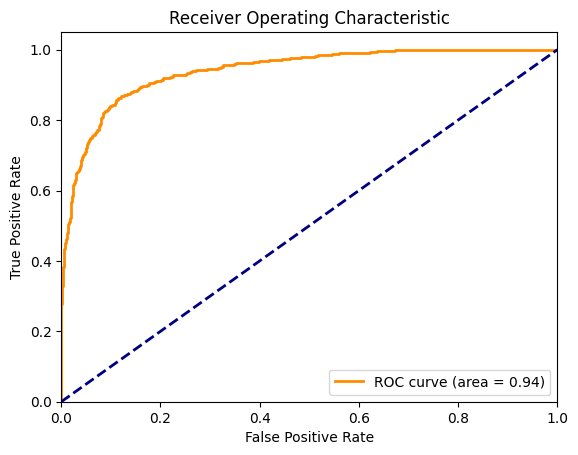

In [ ]:
# 11. Visualización de la Curva ROC
y_pred_proba_best = voting_clf_best.predict_proba(X_test)[:,1]
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_proba_best)
roc_auc_best = auc(fpr_best, tpr_best)
plt.figure()
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_best)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Imprimir los resultados

In [ ]:
# 12. Imprimir los resultados
print('Mejores hiperparámetros: ', best_params)
print("Matriz de Confusión:")
print(conf_matrix_best)
print("\nInforme de Clasificación:")
print(report_best)
print("\nPrecisión del modelo híbrido:", acc_best)

Mejores hiperparámetros:  {'xgb__subsample': 0.9427629804456301, 'xgb__scale_pos_weight': 1.0320900158332558, 'xgb__reg_lambda': 0.7010703016048032, 'xgb__n_estimators': 651, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.13680927343211416, 'xgb__gamma': 0.04500991430601001, 'xgb__colsample_bytree': 0.8770206411553205, 'rf__n_estimators': 166, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_depth': 10, 'rf__bootstrap': False, 'ann__epochs': 10, 'ann__batch_size': 71, 'ann__learning_rate': 0.003320651213411407}
Matriz de Confusión:
[[815 139]
 [110 824]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       954
           1       0.86      0.88      0.87       934

    accuracy                           0.87      1888
   macro avg       0.87      0.87      0.87      1888
weighted avg       0.87      0.87      0.87      1888


Precisión del modelo híbrido: 0.868114406779661
